This notebook produces graphics showing the geographical extent of the default cutouts

In [13]:
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import matplotlib.pyplot as plt
import atlite
import xarray as xr
import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

In [2]:
STATES_TO_REMOVE = [
    "Hawaii", 
    "Alaska", 
    "Commonwealth of the Northern Mariana Islands", 
    "United States Virgin Islands", 
    "Guam", 
    "Puerto Rico", 
    "American Samoa"
]

In [3]:
shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_1_states_provinces"
)
reader = shpreader.Reader(shpfilename)
gdf_states = reader.records()
data = []
for r in gdf_states:
    attr = r.attributes
    if (attr["iso_a2"] in ["US"]) and (attr["name"] not in STATES_TO_REMOVE):
        data.append([attr["name"], attr['iso_a2'], attr["latitude"], attr["longitude"], r.geometry])
gdf_states = gpd.GeoDataFrame(data, columns=["name", "country", "x", "y", "geometry"]).set_crs(4326)

In [6]:
cutout_western = "./../cutouts/western_era5_2019.nc"
cutout_eastern = "./../cutouts/eastern_era5_2019.nc"
cutout_texas = "./../cutouts/texas_era5_2019.nc"
cutout_usa = "./../cutouts/usa_era5_2019.nc"

In [32]:
def plot_cutout(ax, cutout, states, title):
    cells = cutout.grid
    country_bound = gpd.GeoSeries(cells.unary_union)
    plot_grid_dict = dict(
        alpha=0.1,
        edgecolor="k",
        zorder=4,
        aspect="equal",
        facecolor="None",
        transform=plate(),
    )
    states.plot(ax=ax, zorder=1, transform=plate())
    cells.plot(ax=ax, **plot_grid_dict)
    # country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
    ax.set_title(title, fontsize = 16)
    ax.axis('off')
    # cutout.grid.plot(edgecolor="white",linewidth=1,alpha=0.5, ax=ax)

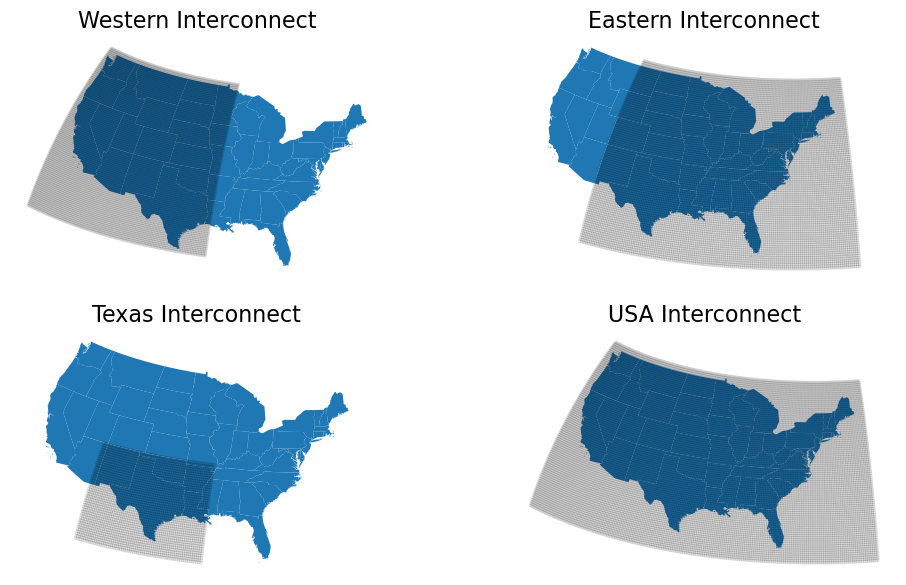

In [36]:
projection = ccrs.Orthographic(-75, 25)
fig, axs = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': projection}, figsize=(12,7))
plot_cutout(
    ax=axs[0,0],
    cutout=atlite.Cutout(cutout_western),
    states=gdf_states,
    title="Western Interconnect"
)
plot_cutout(
    ax=axs[0,1],
    cutout=atlite.Cutout(cutout_eastern),
    states=gdf_states,
    title="Eastern Interconnect"
)
plot_cutout(
    ax=axs[1,0],
    cutout=atlite.Cutout(cutout_texas),
    states=gdf_states,
    title="Texas Interconnect"
)
plot_cutout(
    ax=axs[1,1],
    cutout=atlite.Cutout(cutout_usa),
    states=gdf_states,
    title="USA Interconnect"
)

In [37]:
units_mapper = {
    "height":"m",
    "wnd100m":"ms**-1",
    "wnd_azimuth":"m s**-1",
    "roughness":"m",
    "influx_toa":"Wm**-2",
    "influx_direct":"Wm**-2",
    "influx_diffuse":"Wm**-2",
    "albedo":"-",
    "solar_altitude":"rad",
    "solar_azimuth":"rad",
    "temperature":"K",
    "soil temperature":"K",
    "runoff":"m",
}

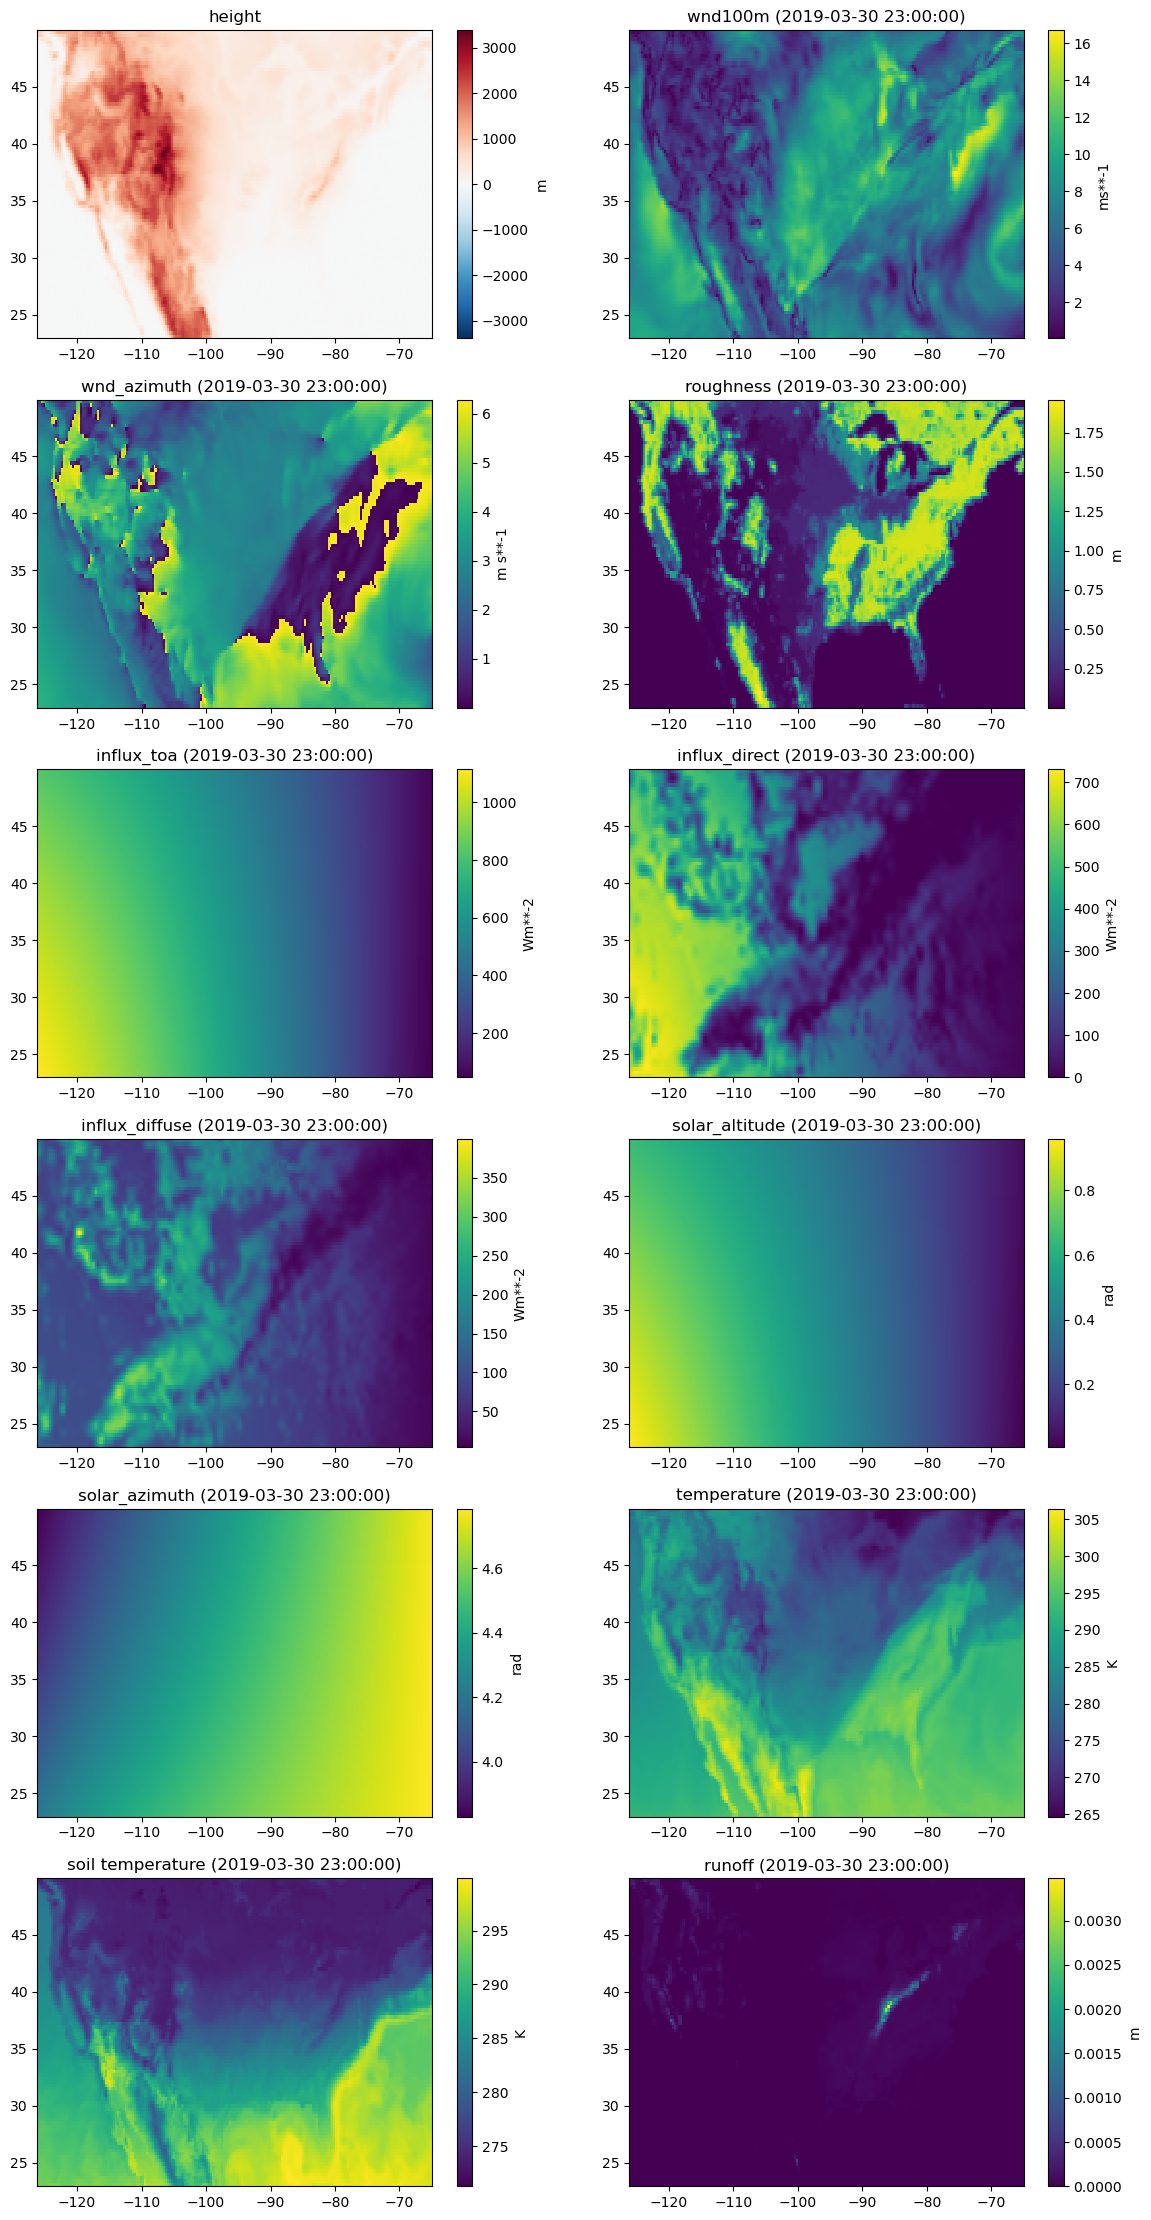

In [38]:
cutout = atlite.Cutout(cutout_usa)
time_to_plot = "2019-03-30 23:00:00"
# cutout.data.wnd100m.sel(time="2019-03-30 23:00:00").plot()
ax_idx = 0
ax_idy = 0
fig, axs = plt.subplots(6, 2, figsize=(14, 28))
for var in cutout.data.data_vars:
    if var == "albedo":
        continue
    if "time" in cutout.data[var].coords:
        cutout.data[var].sel(time=time_to_plot).plot(ax=axs[ax_idy, ax_idx], cbar_kwargs={"label": units_mapper[var]})
        axs[ax_idy, ax_idx].set_title(f"{var} ({time_to_plot})")
    else:
        cutout.data[var].plot(ax=axs[ax_idy, ax_idx], cbar_kwargs={"label": units_mapper[var]})
        axs[ax_idy, ax_idx].set_title(f"{var}")
    
    axs[ax_idy, ax_idx].set_ylabel("")
    axs[ax_idy, ax_idx].set_xlabel("")
    
    ax_idx = (ax_idx + 1) % 2
    if ax_idx == 0:
        ax_idy += 1

In [13]:
cap_factors = cutout.wind(turbine="Vestas_V112_3MW", capacity_factor=True)

[########################################] | 100% Completed | 118.54 s


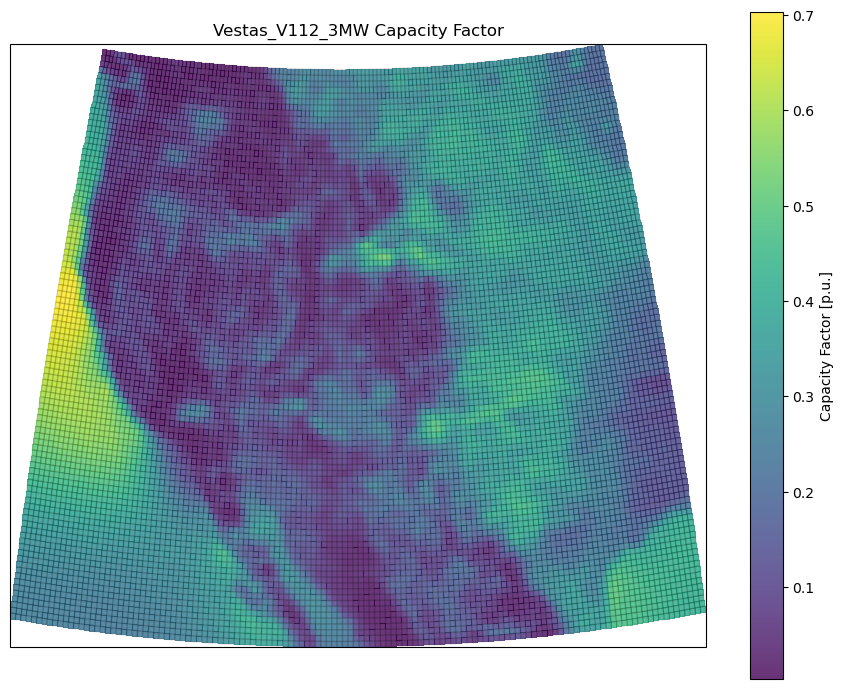

In [17]:
from cartopy.crs import PlateCarree as plate
import cartopy.crs as ccrs
projection = ccrs.Orthographic(-110, 40)
plot_grid_dict = dict(
    alpha=0.1,
    edgecolor="k",
    zorder=4,
    aspect="equal",
    facecolor="None",
    transform=plate(),
)
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(9, 7))
cap_factors.name = "Capacity Factor"
cap_factors.plot(ax=ax, transform=plate(), alpha=0.8)
cells = cutout.grid
cells.plot(ax=ax, **plot_grid_dict)
plt.title("Vestas_V112_3MW Capacity Factor")
fig.tight_layout()